## imports

In [1]:
import numpy as np
from numpy import sqrt, abs, pi, exp, diag, mean, min, max, sum, eye
from numpy.linalg import norm, inv
import math
import matplotlib.pyplot as plt
import time

In [2]:
import torch

## function & derivatives

In [3]:
def rosenbrock(x):
    d = x.shape[1]
    n = x.shape[0]

    sum = 0

    for i in range(d-1):
        sum += 100 * (x[:,i+1] - x[:,i]**2)**2 + (1 - x[:,i])**2

    return sum.astype('float32')
# shape is p x N

In [4]:
def rosenbrock_grad(x):
    d = x.shape[1]
    n = x.shape[0]

    gradf = np.zeros((n,d))
    gradf[:, 0] = -400 * (x[:, 1] - x[:, 0]**2) * x[:, 0] - 2 * (1 - x[:, 0])
    gradf[:, d-1] = 200 * (x[:, d-1] - x[:, d-2]**2)

    for i in range(1,d-1):
        gradf[:, i] = - 400 * (x[:, i+1] - x[:, i]**2) * x[:, i] - 2 * (1 - x[:, i]) + 200 * (x[:,i] - x[:,i-1]**2)

    return gradf.astype('float32')
# shape is p x N

## func, xmean, dim

In [5]:
N = 5000
strfitnessfct = rosenbrock
strgrad = rosenbrock_grad
xmean = 1.1*np.ones((N,1)) + 0.01 * np.random.randn(N,1)

In [6]:
xmean.shape

(5000, 1)

## initialisations

In [7]:
stopfitness = 1e-3

In [8]:
xmean = xmean.astype('float32')
xmin = xmean

In [9]:
R = 0.1 * np.ones((1,N))
Γ = np.zeros((N,1), dtype = np.float32)
p = 5
cs = 0.1
it = 0
prev = 0
θ = 0.1
Δ = 0
x_st = xmean
fXX = (strfitnessfct(xmean.T))

## helper functions

In [10]:
def generate_arx(x, r, num = 5):
    return np.concatenate([x,x + (r * (2*np.random.rand(num-1, x.shape[0])-1)).T], axis = 1)

In [11]:
def sorted_x_y_grad(x, grads = True):
    if grads == True:
        y = strfitnessfct(x.T)
        y_grad = strgrad(x.T).T
        
        y_sorted = np.sort(y)
        sorted_indices = np.argsort(y)
        y_grad_sorted = y_grad[:,sorted_indices]
        x_sorted = x[:, sorted_indices]
        fittest = x_sorted[:,0:1]

        return x_sorted, y_sorted[0], y_grad_sorted, fittest
    else:
        y = strfitnessfct(x.T)
        y_sorted = np.sort(y)
        sorted_indices = np.argsort(y)
        x_sorted = x[:, sorted_indices]
        fittest = x_sorted[:,0:1]
        worst = x_sorted[:,-1:]

        return fittest, worst, y_sorted[0]

In [12]:
def calc_invH(x, x_grad, γ = 1):
    a = x - np.mean(x, axis = 1).reshape(-1,1)
    b = x_grad - np.mean(x_grad, axis = 1).reshape(-1,1)
    c = np.sum(a*b, axis = 1)
    d = np.sum(b*b, axis = 1)
    Hinv = (c / d).reshape(-1,1)
    Hinv = np.nan_to_num(Hinv)
    Hinv[Hinv<0] = 0.0
    return Hinv**γ

In [13]:
def cal_R(xmin, xmax, ps, cs = 0.1):
    ps = (1 - cs) * ps + cs * (xmax - xmin)
    sig = np.minimum(np.abs(ps.T), 0.01 * np.ones_like(ps.T))
    sig[sig == 0] = 0.01
    return sig, ps

In [14]:
def update_ensemble(x, α, Δ):
    K = Δ
    x1 = x - α * Δ
    return x1, K

In [15]:
def increment(K, B, G, θ=0.9):
    return θ * K + B * G

In [18]:
def wolfe_step(g, Hg, x, loss):
    
    step = 0.1
    c_1 = 0.01
    pvec = - Hg
    γ = 1.0
    
    while γ > 1e-6:
        new_x = x.reshape(-1,1) + γ * pvec.reshape(-1,1)
        loss_new = strfitnessfct(new_x.T)
        g_new = strgrad(new_x.T)
        min_loss = c_1 * γ * pvec @ g
        armijo = loss_new - loss - min_loss

        if armijo < -0:
            step = γ
            x = new_x.reshape(-1,1)
            break
            
        else:
            γ *= 0.5

    return step

# FINDER

In [19]:
tic = time.time()
while True:
    
    '''
    sampling around xmean
    '''
    arx = generate_arx(xmin, R)
    '''
    gradient computation and sorting initial ensemble
    '''
    arx_sorted, least_fitness, gradf_sorted, xmiin = sorted_x_y_grad(arx, grads=True)
    
    '''
    diagonal approximation to the stochastic mimic of the inverse Hessian
    '''
    B = calc_invH(arx_sorted, gradf_sorted)
    
    '''
    increment term
    '''
    Δ_sorted = increment(prev, B, gradf_sorted, θ)

    '''
    update ensemble
    '''
    α = wolfe_step(gradf_sorted[:, 0], Δ_sorted[:,0], arx_sorted[:, 0], least_fitness)
    arx_new, prev = update_ensemble(arx_sorted, α, Δ_sorted)
    
    '''
    new ensemble
    '''
    arx_new1 = np.concatenate([arx_new, xmiin], axis = 1)
    
    '''
    search radius update
    '''
    xmin, xmax, min_fitness = sorted_x_y_grad(arx_new1, grads=False)
    R, Γ = cal_R(xmin, xmax, Γ)
    
    '''
    storing varibales for plotting
    '''
    x_st = np.concatenate([x_st, xmin], axis = 1)
    fXX = np.concatenate([fXX, np.array([min_fitness])], axis = 0)
    
    '''
    iteration count update and printing
    '''
    if it == 0:
        print(it, "\t", fXX[it],"\n")
    it += 1
    print(it,"\t", fXX[it],"\n")
    
    '''
    termination criteria
    '''
    if fXX[-1] <= stopfitness:
        break
toc = time.time()
print("finished training in ",toc-tic," seconds")

0 	 6398.524 

1 	 4121.5815 

2 	 3012.1467 

3 	 2330.9673 

4 	 1799.737 

5 	 1405.0417 

6 	 1097.504 

7 	 868.04193 

8 	 687.7817 

9 	 549.256 

10 	 443.89987 

11 	 364.5658 

12 	 307.361 

13 	 262.60352 

14 	 222.8466 

15 	 188.50897 

16 	 155.98384 

17 	 125.83601 

18 	 102.762314 

19 	 81.81524 

20 	 64.29354 

21 	 52.18862 

22 	 42.70411 

23 	 33.843975 

24 	 26.952055 

25 	 20.193089 

26 	 14.334012 

27 	 10.632721 

28 	 7.1885357 

29 	 5.854557 

30 	 4.2602677 

31 	 2.8939734 

32 	 2.1298363 

33 	 1.4964675 

34 	 1.1197692 

35 	 0.73116034 

36 	 0.49023092 

37 	 0.322525 

38 	 0.20218964 

39 	 0.13212869 

40 	 0.09005685 

41 	 0.06209393 

42 	 0.04402346 

43 	 0.03189509 

44 	 0.02534247 

45 	 0.019200705 

46 	 0.0155458 

47 	 0.01340563 

48 	 0.01200599 

49 	 0.011006041 

50 	 0.010431644 

51 	 0.009938288 

52 	 0.009675433 

53 	 0.009497454 

54 	 0.009372246 

55 	 0.009284542 

56 	 0.009224969 

57 	 0.009181757 

58 	 0.0

/tmp/ipykernel_3603090/1061633993.py:6: RuntimeWarning: invalid value encountered in divide
  Hinv = (c / d).reshape(-1,1)


269 	 0.006365721 

270 	 0.0063501685 

271 	 0.0063389693 

272 	 0.0063319267 

273 	 0.0063241236 

274 	 0.006317669 

275 	 0.0063036433 

276 	 0.006291239 

277 	 0.0062774904 

278 	 0.0062643746 

279 	 0.0062528984 

280 	 0.0062450916 

281 	 0.006226619 

282 	 0.0062187966 

283 	 0.006209394 

284 	 0.006180573 

285 	 0.006170935 

286 	 0.006153161 

287 	 0.0061454494 

288 	 0.0061369897 

289 	 0.0061231195 

290 	 0.0061130715 

291 	 0.0061030798 

292 	 0.006096617 

293 	 0.0060867905 

294 	 0.0060779713 

295 	 0.0060722847 

296 	 0.0060663065 

297 	 0.0060634757 

298 	 0.0060561975 

299 	 0.0060481518 

300 	 0.0060437247 

301 	 0.0060337274 

302 	 0.006020548 

303 	 0.0060066637 

304 	 0.005998004 

305 	 0.005983629 

306 	 0.0059743286 

307 	 0.0059633697 

308 	 0.0059528383 

309 	 0.005943944 

310 	 0.0059322068 

311 	 0.005920734 

312 	 0.00591132 

313 	 0.0059006037 

314 	 0.005889896 

315 	 0.005879808 

316 	 0.0058698226 

317 	 0.00

# Adam

In [20]:
from numpy.random import rand
from numpy import sqrt
# xx_st = xmean
fx_st = []
def adam(objective, n_iter, alpha, beta1 = 0.9, beta2 = 0.999, eps=1e-8):
    # generate an initial point
    global xx_st
    xx_st = xmean
    x = xmean  # Initialize with random values
    score = objective(x.T)
    # initialize first and second moments
    m = [0.0 for _ in range(len(x))]
    v = [0.0 for _ in range(len(x))]
    # run the gradient descent updates
    for t in range(n_iter):
        # calculate gradient g(t)
        g = strgrad(x.T)
        g = g.T
        # build a solution one variable at a time
        # print(len(x))
        # print(g.shape)
        for i in range(len(x)):
            # m(t) = beta1 * m(t-1) + (1 - beta1) * g(t)
            m[i] = beta1 * m[i] + (1.0 - beta1) * g[i]
            # v(t) = beta2 * v(t-1) + (1 - beta2) * g(t)^2
            v[i] = beta2 * v[i] + (1.0 - beta2) * g[i]**2
            # mhat(t) = m(t) / (1 - beta1(t))
            mhat = m[i] / (1.0 - beta1**(t+1))
            # vhat(t) = v(t) / (1 - beta2(t))
            vhat = v[i] / (1.0 - beta2**(t+1))
            # x(t) = x(t-1) - alpha * mhat(t) / (sqrt(vhat(t)) + eps)
            x[i] = x[i] - alpha * mhat / (sqrt(vhat) + eps)
        # evaluate candidate point
        score = strfitnessfct(x.T)
        fx_st.append(score)
        xx_st = np.concatenate([xx_st, x], axis = 1)
        # report progress
        print('>%d f() = %.5f' % (t, score))
        if score < 1e-3:
            print("------")
            break
    
    return [x, score, xx_st]


In [21]:
tic = time.time()
_, f, xx_st = adam(rosenbrock, 20000, 1e-3)

toc = time.time()
print(toc - tic)

/tmp/ipykernel_3603090/2927474347.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('>%d f() = %.5f' % (t, score))


>0 f() = 6264.76758
>1 f() = 6133.10498
>2 f() = 6003.44092
>3 f() = 5875.72412
>4 f() = 5749.87793
>5 f() = 5625.88184
>6 f() = 5503.71582
>7 f() = 5383.35791
>8 f() = 5264.81445
>9 f() = 5148.06982
>10 f() = 5033.13184
>11 f() = 4920.01562
>12 f() = 4808.70703
>13 f() = 4699.21582
>14 f() = 4591.54004
>15 f() = 4485.68604
>16 f() = 4381.64160
>17 f() = 4279.40576
>18 f() = 4178.97852
>19 f() = 4080.37012
>20 f() = 3983.53491
>21 f() = 3888.49561
>22 f() = 3795.23145
>23 f() = 3703.73828
>24 f() = 3613.98926
>25 f() = 3525.98682
>26 f() = 3439.70679
>27 f() = 3355.14136
>28 f() = 3272.26172
>29 f() = 3191.06006
>30 f() = 3111.52295
>31 f() = 3033.62158
>32 f() = 2957.34277
>33 f() = 2882.66406
>34 f() = 2809.56519
>35 f() = 2738.02759
>36 f() = 2668.02661
>37 f() = 2599.54810
>38 f() = 2532.55273
>39 f() = 2467.04834
>40 f() = 2402.97705
>41 f() = 2340.34253
>42 f() = 2279.10791
>43 f() = 2219.26611
>44 f() = 2160.77271
>45 f() = 2103.62256
>46 f() = 2047.77942
>47 f() = 1993.23181
>4

# plotting

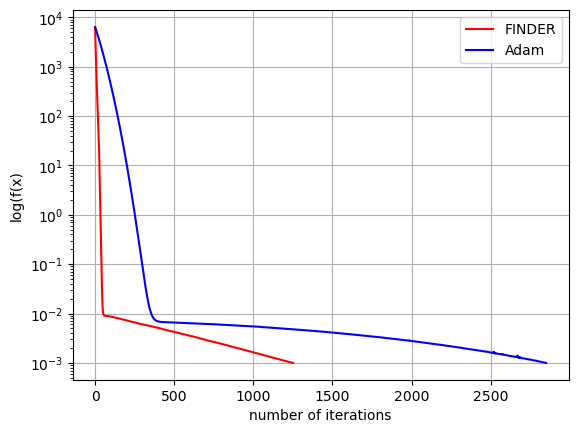

In [23]:
plt.style.use('default')
plt.plot(fXX,'r', label = 'FINDER')
plt.plot(fx_st,'b', label='Adam')
plt.yscale('log')
plt.legend()
plt.xlabel("number of iterations")
plt.ylabel("log(f(x)")
plt.grid()
plt.show()